# M05T06 - Speeding Up

> Demonstration of speed-ups with different libraries and paradigms.

The topics covered are:
* The power of Numpy.
* The power of GPUs.

## Dependencies

In [1]:
# dependencies
import cupy as cp
import math
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


## The Power of Numpy

A naive way to initialize a sequence `x` within `[-5.0, 5.0]` with a total of `dim` points is

```
X = list()
for i in range(dim):
    X.append(i / dim * 10.0 - 5.0)
```

But one can also use list comprehension...

```
X = [i / dim * 10.0 - 5.0 for i in range(dim)]
```

Or alternatively, Numpy arrays...

```
X = numpy.linspace(0.0, 10.0, dim) - 5.0
```

Let's compare the individual speeds of each of these as we increase the dimension of the list.

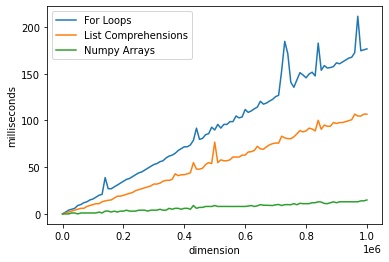

In [2]:
# initialize
times = [list(), list(), list()]
dims = list(range(0, 1000001, 10000))
# iterate
for dim in dims:
    # for loops
    _start = time.time() * 1e3
    X = list()
    for i in range(dim):
        X.append(i / dim * 10.0 - 5.0)
    times[0].append(time.time() * 1e3 - _start)

    # list comprehensions
    _start = time.time() * 1e3
    X = [i / dim * 10.0 - 5.0 for i in range(dim)]
    times[1].append(time.time() * 1e3 - _start)

    # Numpy arrays
    _start = time.time() * 1e3
    X = np.linspace(0.0, 10.0, dim) - 5.0
    times[2].append(time.time() * 1e3 - _start)

# figure
plt.plot(dims, times[0], dims, times[1], dims, times[2])
plt.legend(['For Loops', 'List Comprehensions', 'Numpy Arrays'])
plt.ylabel('milliseconds')
plt.xlabel('dimension')
plt.show()

Well, Numpy-based initialization is definitely fast! 

But let's put some number crunching and see how they do then.
Let us take the Gaussian function $v(X) = \frac{1}{4 \pi^{2} \sqrt{| \sigma |}} e^{\frac{-1}{2} X^{T} \sigma^{-1} X}$, where $X$ is the sequence we just defined.
Putting it all together, 

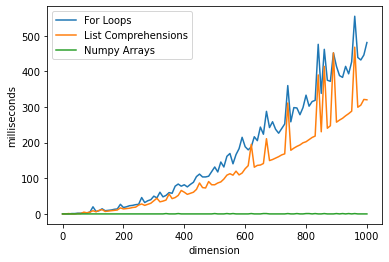

In [3]:
# initialize
times = [list(), list(), list()]
dims = list(range(0, 1001, 10))
# iterate
for dim in dims:
    # constant matrix
    sigma = np.eye(dim)
    sigma_inv = np.linalg.inv(sigma)
    sigma_det = np.linalg.det(sigma)

    # for loops
    X = list()
    for i in range(dim):
        X.append(i / dim * 10.0 - 5.0)
    _start = time.time() * 1e3
    _exp = 0.0
    for i in range(dim):
        _sum = 0.0
        for j in range(dim):
            _sum += sigma[i][j] * X[j]
        _exp += - 1 / 2 * X[i] * _sum
    v = math.exp(_exp) / 4 / math.pi**2 / math.sqrt(sigma_det)
    times[0].append(time.time() * 1e3 - _start)

    # list comprehensions
    X = [i / dim * 10.0 - 5.0 for i in range(dim)]
    _start = time.time() * 1e3
    V = math.exp(sum([-1 / 2 * X[i] * sum([sigma[i][j] * X[j] for j in range(dim)]) for i in range(dim)])) / 4 / math.pi**2 / math.sqrt(sigma_det)
    times[1].append(time.time() * 1e3 - _start)

    # Numpy arrays
    X = np.linspace(0.0, 10.0, dim) - 5.0
    _start = time.time() * 1e3
    V = np.exp(-1 / 2 * np.dot(np.transpose(X), np.dot(sigma_inv, X))) / 4 / np.pi**2 / np.sqrt(sigma_det)
    times[2].append(time.time() * 1e3 - _start)

# figure
plt.plot(dims, times[0], dims, times[1], dims, times[2])
plt.legend(['For Loops', 'List Comprehensions', 'Numpy Arrays'])
plt.ylabel('milliseconds')
plt.xlabel('dimension')
plt.show()

Numpy still wins by a huge margin!
But what about parallel computing? 
Let's find out...

## The Power of GPUs

Let's take a look at two other competing libraries, TensorFlow and CuPy which can run computations on GPUs.

For this, we take the same Gaussian function but define the covariance matrix individually inside those libararies.

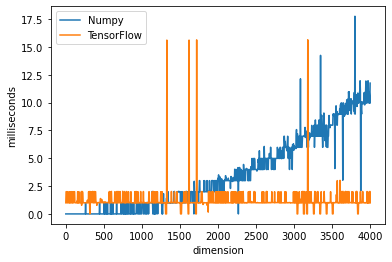

In [6]:
# initialize
times = [list(), list()]
dims = list(range(0, 4001, 4))
# iterate for Numpy arrays
for dim in dims:
    sigma = np.eye(dim)
    sigma_inv = sigma
    sigma_det = 1.0
    X = np.linspace(0.0, 10.0, dim) - 5.0
    _start = time.time() * 1e3
    V = np.exp(-1 / 2 * np.dot(np.transpose(X), np.dot(sigma_inv, X))) / 4 / np.pi**2 / np.sqrt(sigma_det)
    times[0].append(time.time() * 1e3 - _start)

# iterate for TensorFlow arrays
for dim in dims:
    sigma = tf.eye(dim)
    sigma_inv = sigma
    sigma_det = 1.0
    X = tf.linspace(0.0, 10.0, dim) - 5.0
    _start = time.time() * 1e3
    V = tf.exp(-1 / 2 * tf.tensordot(tf.transpose(X), tf.tensordot(sigma_inv, X, 1), 1)) / 4 / np.pi**2 / tf.sqrt(sigma_det)
    times[1].append(time.time() * 1e3 - _start)

# figure
plt.plot(dims, times[0], dims, times[1])
plt.legend(['Numpy', 'TensorFlow'])
plt.ylabel('milliseconds')
plt.xlabel('dimension')
plt.show()

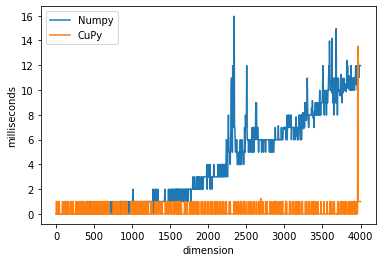

In [7]:
# initialize
times = [list(), list()]
dims = list(range(0, 4001, 4))

# iterate for Numpy arrays
for dim in dims:
    sigma = np.eye(dim)
    sigma_inv = sigma
    sigma_det = 1
    X = np.linspace(0.0, 10.0, dim) - 5.0
    _start = time.time() * 1e3
    V = np.exp(-1 / 2 * np.dot(np.transpose(X), np.dot(sigma_inv, X))) / 4 / np.pi**2 / np.sqrt(sigma_det)
    times[0].append(time.time() * 1e3 - _start)

# iterate for CuPy arrays
for dim in dims:
    sigma = cp.eye(dim)
    sigma_inv = sigma
    sigma_det = 1
    X = cp.linspace(0.0, 10.0, dim) - 5.0
    _start = time.time() * 1e3
    V = cp.exp(-1 / 2 * cp.dot(cp.transpose(X), cp.dot(sigma_inv, X))) / 4 / cp.pi**2 / cp.sqrt(sigma_det)
    times[1].append(time.time() * 1e3 - _start)

plt.plot(dims, times[0], dims, times[1])
plt.legend(['Numpy', 'CuPy'])
plt.ylabel('milliseconds')
plt.xlabel('dimension')
plt.show()